In [62]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt

In [63]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('CPU'))


2.18.0
Num GPUs Available: 0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# 1. Remove dodgy images

In [64]:
import cv2
import imghdr

In [4]:
import cv2
print(cv2.__version__)


4.11.0


In [5]:
data_dir='Datasets'

here we are creating a variable for directory to reach the dataset folders Happy people and Sad people

In [6]:
os.listdir(data_dir)

['Happy People', 'Sad People']

In [7]:
img_format=['jpg','png','bmp','jpeg']

In [56]:
img1_path=os.path.join(data_dir,'Healthy','sp4-H21.jpg')
img1=cv2.imread(img1_path)


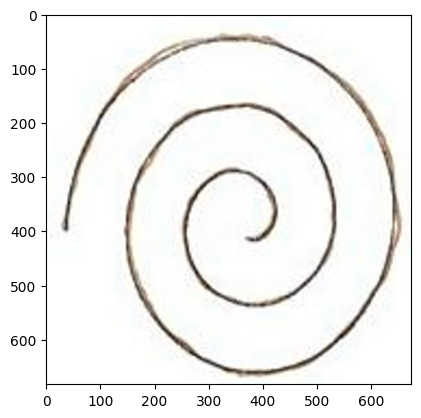

In [12]:
plt.imshow(img1)

We are iterating over all images downloaded from the browser to delete dodgy images if they fall in the criteria set in the try exception block.

In [13]:
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    
    if os.path.isdir(class_path):  # Ensure it's a directory
        for image in os.listdir(class_path):
            image_path = os.path.join(class_path, image)
            
            if os.path.isfile(image_path):  # Ensure it's a file
                try:
                    img = cv2.imread(image_path)  # Corrected function
                    tip = imghdr.what(image_path)  # Get image format
                    
                    if tip not in img_format:
                        print(f"Image not in the format list: {image_path}")
                        os.remove(image_path)  # Remove incorrect format image
                
                except Exception as e:
                    print(f"Issue with image {image_path}: {str(e)}")

# 2. Data Processing

"tf.data.Dataset" is a TensorFlow API used to handle large datasets efficiently. It provides a way to create, transform, and load data in an optimized pipeline for machine learning models.

In [14]:
tf.data.Dataset??

Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
class DatasetV2(
    collections_abc.Iterable,
    tracking_base.Trackable,
    composite_tensor.CompositeTensor,
    data_types.DatasetV2,
    metaclass=abc.ABCMeta):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dty

Why Use image_dataset_from_directory?

✅ Loads images directly from a folder (no need for manual cv2.imread() or PIL.Image.open()).

✅ Automatically labels images based on folder names.

✅ Supports rescaling, batching, and shuffling for deep learning training.

✅ Works seamlessly with TensorFlow/Keras models.

tf.keras.utils.image_dataset_from_directory is a TensorFlow utility used to load and preprocess images directly from a directory structure. It automatically creates a tf.data.Dataset, making it easy to train deep learning models with image data.

In [15]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)
Source:   
@keras_export(
    [
        "keras.utils.image_dataset_from_directory",
        "keras.preprocessing.image_dataset_from_directory",
    ]
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    ve

## Load data

used keras to load the data. Simplifies the process and performs some preprocessing to it. 

Additional benefit, it shuffles the data in the pipeline. So no need to shuffle it manually

In [16]:
data = tf.keras.utils.image_dataset_from_directory('Datasets')

Found 264 files belonging to 2 classes.


### This data set is divided into classes( each class for a unique label), then are segregated into batches of 32(can be change) elements

In [17]:
class_names = data.class_names
print("Classes:", class_names)

Classes: ['Happy People', 'Sad People']


## Retrieve and Display the ith Image in the First Batch

We used keras for data processing, thus the data type of dataset is a spl one i.e keras-datatype
As this data is not loaded in a numpy array so retrieval will not be the in the usual method data[0], 

So for easy retrieval, lets convert this dataset into numpy type

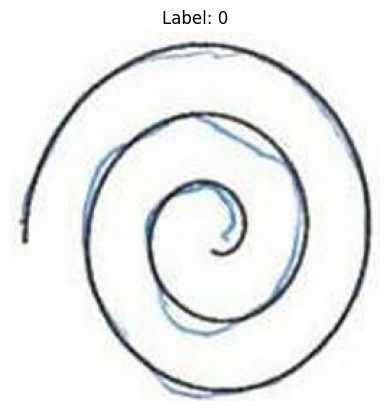

In [18]:
batch_number = 2  # Get the 3rd batch (0-based index)
image_index = 3   # Get the 4th image in that batch

# Iterate through the dataset to reach the desired batch
for i, (batch_images, batch_labels) in enumerate(data):
    if i == batch_number:
        image = batch_images[image_index].numpy().astype("uint8")
        label = batch_labels[image_index].numpy()
        break  # Stop after retrieving the required batch

# Display the image
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()


## Scaling Data

In [19]:
data = data.map(lambda x,y:(x/255, y))

In [20]:
# Length of data shows the number of batches inside the data.
len(data)

9

In [21]:
scaled_iterator=data.as_numpy_iterator()

In [22]:
batch=scaled_iterator.next()

Trying to retrieve one image from the batch, the batch STRUCTURE = images mapped with labels ->> images,labels, so making img and lbl as array

In [23]:
img,lbls=batch
len(img)

32

## Splitting Data

In [24]:
# define size for train, evaluate and test
train_len = int(len(data) * 0.7)
eval_len = int(len(data) * 0.2)

# added one bec int(len(data)*0.1) is resulting in 0, that shouldn't happen 

In [25]:
train_len

6

How take() and skip() Work
.take(n): Takes the first n elements from the dataset.
.skip(n): Skips the first n elements and returns the rest.

Works well only when the data is shuffled

In [26]:
train_data = data.take(train_len)
eval_data = data.skip(train_len).take(eval_len)

In [27]:
# Dynamically calculate the remaining test set size
remaining_data = (train_len + eval_len)
test_data = data.skip(remaining_data).take(len(data)-remaining_data)  # Take all remaining data

In [28]:
len(test_data)

2

# Deep learning

## Building Model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout

In [30]:
model=Sequential()

model.add(Conv2D(16,(3,3), 1, activation='relu', input_shape=(256,256,3))) #input shape, 256 px height, 256px width, 3 channels deep
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(16, (3,3), 1, activation= 'relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


C:\Users\dihsa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(train_data, epochs=10, validation_data=eval_data)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 578ms/step - accuracy: 0.5957 - loss: 1.0632 - val_accuracy: 0.4688 - val_loss: 0.7374
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - accuracy: 0.4644 - loss: 0.7155 - val_accuracy: 0.5000 - val_loss: 0.6845
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - accuracy: 0.4682 - loss: 0.6848 - val_accuracy: 0.4375 - val_loss: 0.6561
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - accuracy: 0.6426 - loss: 0.6348 - val_accuracy: 0.7500 - val_loss: 0.5497
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - accuracy: 0.8383 - loss: 0.4407 - val_accuracy: 0.7500 - val_loss: 0.5394
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 490ms/step - accuracy: 0.8545 - loss: 0.3920 - val_accuracy: 0.9062 - val_loss: 0.2564
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 480ms/step - accuracy: 0.9651 - loss: 0.1729 - val_accuracy: 0.9688 - val_loss: 0.1516
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 485ms/step - accuracy: 0.9184 - loss: 0.2081 - val_accuracy: 0.8750 - val_loss:

In [34]:
loss, accuracy = model.evaluate(eval_data)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step - accuracy: 0.9688 - loss: 0.1409
Validation Loss: 0.1409
Validation Accuracy: 0.9688


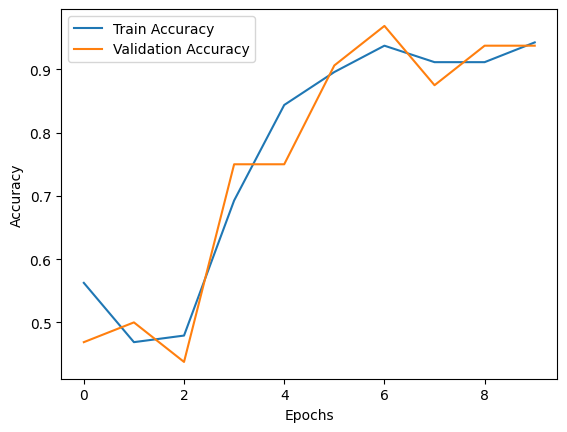

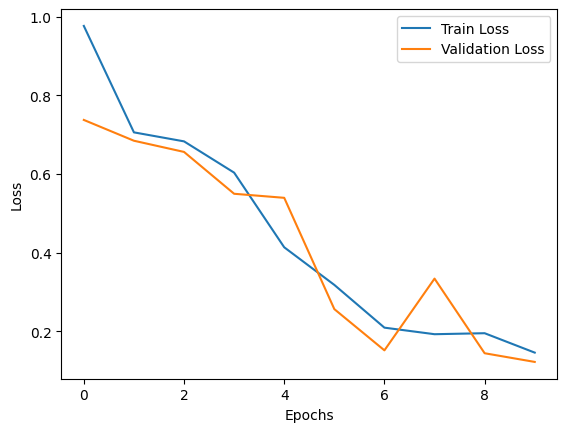

In [35]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evalute Performance

In [36]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [37]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [38]:
len(test_data)

2

In [39]:
for batch in test_data.as_numpy_iterator():
    X,y = batch
    y_pred = model.predict(X)
    pre.update_state(y,y_pred)
    re.update_state(y,y_pred)
    acc.update_state(y,y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


In [40]:
print(f'Presicion: {pre.result()}, Recall: {re.result()}, BinaryAccuracy: {acc.result()}')

Presicion: 1.0, Recall: 1.0, BinaryAccuracy: 1.0


# Testing Model On External Image

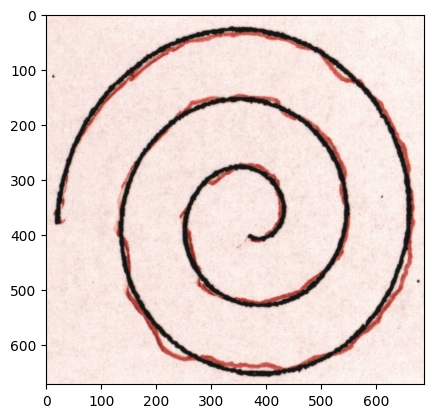

In [57]:
import tensorflow as tf
import numpy as np
import cv2

# Load image

image_path = r"C:\Users\dihsa\anaconda_projects\DL\Datasets\Patient\sp1-P13.jpg"
image = cv2.imread(image_path)  # Read the image
plt.imshow(image)

In [58]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
image = cv2.resize(image, (256, 256))  # Resize to model's input size

# Normalize pixel values (0-255 → 0-1)
image = image / 255.0

# Expand dimensions to match model input (batch of 1)
image = np.expand_dims(image, axis=0)

# Check shape
print("Image shape after preprocessing:", image.shape)  # Should be (1, 256, 256, 3)

Image shape after preprocessing: (1, 256, 256, 3)


In [59]:
prediction = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


In [60]:
print(f"Predicted Class: {prediction}")

if prediction<0.5:
    predicted_class=0
else:
    predicted_class=1

Predicted Class: [[0.6601645]]


In [61]:
class_names = ["Healthy", "Patient"]
print(f"Predicted State: {class_names[predicted_class]}")


Predicted State: Patient
